<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b> Сегментация изображений</b></h3>




Отчет вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>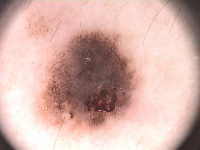</td><td>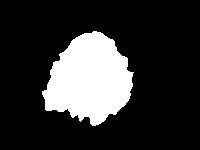</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

####  Data Load

In [2]:
!pip install googledrivedownloader
#!apt install unrar
!pip install torchinfo

In [3]:
import torchinfo
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from time import time
from collections import OrderedDict
import pandas as pd

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
import gc
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

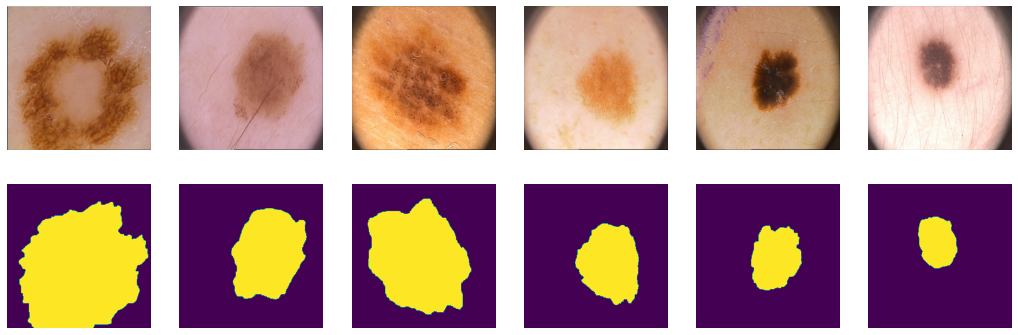

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
np.random.seed(30)

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet 


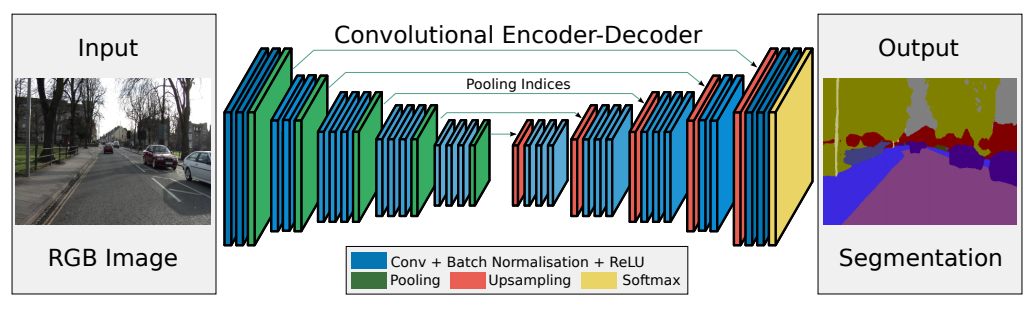

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрим из чего состоит модель и для чего выбраны те или иные блоки.

In [4]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        self.enc_conv0 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(3, 64, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(64)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(64, 64, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(64)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool0 = nn.MaxPool2d(2, stride = 2, return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(64, 128, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(128)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(128, 128, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(128)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool1 = nn.MaxPool2d(2, stride = 2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(128, 256, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(256)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(256, 256, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(256)),
                 ('relu2', nn.ReLU(inplace = True)),
                 ('conv3', nn.Conv2d(256, 256, 3, stride = 1, padding = 1)),
                 ('bn3', nn.BatchNorm2d(256)),
                 ('relu3', nn.ReLU(inplace = True))])
        )
        self.pool2 = nn.MaxPool2d(2, stride = 2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(256, 512, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(512)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(512)),
                 ('relu2', nn.ReLU(inplace = True)),
                 ('conv3', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn3', nn.BatchNorm2d(512)),
                 ('relu3', nn.ReLU(inplace = True))])
        )
        self.pool3 = nn.MaxPool2d(2, stride = 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(512)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(512)),
                 ('relu2', nn.ReLU(inplace = True)),
                 ('conv3', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn3', nn.BatchNorm2d(512)),
                 ('relu3', nn.ReLU(inplace = True)),
                 ('pool', nn.MaxPool2d(2, stride = 2, return_indices=True)),
                 ('unpool', nn.MaxUnpool2d(2, stride = 2)),
                 ('conv3', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn3', nn.BatchNorm2d(512)),
                 ('relu3', nn.ReLU(inplace = True)),
                 ('conv4', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn4', nn.BatchNorm2d(512)),
                 ('relu4', nn.ReLU(inplace = True)),
                 ('conv5', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn5', nn.BatchNorm2d(512)),
                 ('relu5', nn.ReLU(inplace = True))])
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(2, stride = 2) # 16 -> 32
        self.dec_conv0 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(512)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(512)),
                 ('relu2', nn.ReLU(inplace = True)),
                 ('conv3', nn.Conv2d(512, 256, 3, stride = 1, padding = 1)),
                 ('bn3', nn.BatchNorm2d(256)),
                 ('relu3', nn.ReLU(inplace = True))])
        )
        
        self.upsample1 = nn.MaxUnpool2d(2, stride = 2) # 32 -> 64
        self.dec_conv1 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(256, 256, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(256)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(256, 256, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(256)),
                 ('relu2', nn.ReLU(inplace = True)),
                 ('conv3', nn.Conv2d(256, 128, 3, stride = 1, padding = 1)),
                 ('bn3', nn.BatchNorm2d(128)),
                 ('relu3', nn.ReLU(inplace = True))])
        )
        
        self.upsample2 = nn.MaxUnpool2d(2, stride = 2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(128, 128, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(128)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(128, 64, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(64)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        
        self.upsample3 = nn.MaxUnpool2d(2, stride = 2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(64, 64, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(64)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(64, 1, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(1))])
        )
        
    def forward(self, x):
        # encoder
        e0, i0 = self.pool0(self.enc_conv0(x))
        sh0 = self.enc_conv0(x).size()
        e1, i1 = self.pool1(self.enc_conv1(e0))
        sh1 = self.enc_conv1(e0).size()
        e2, i2 = self.pool2(self.enc_conv2(e1))
        sh2 = self.enc_conv2(e1).size()
        e3, i3 = self.pool3(self.enc_conv3(e2))
        sh3 = self.enc_conv3(e2).size()

        # bottleneck
        b, ibn = self.bottleneck_conv[:10](e3)
        shbn = self.bottleneck_conv[:9](e3).size()
        b = self.bottleneck_conv[10](b, ibn, output_size = shbn)
        b = self.bottleneck_conv[11:](b)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, i3, output_size = sh3))
        d1 = self.dec_conv1(self.upsample1(d0, i2, output_size = sh2))
        d2 = self.dec_conv2(self.upsample2(d1, i1, output_size = sh1))
        d3 = self.dec_conv3(self.upsample3(d2, i0, output_size = sh0))  # no activation
        return d3

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

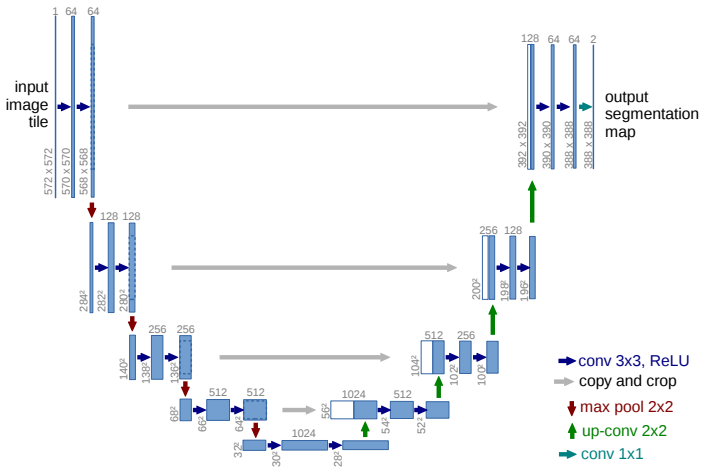

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [5]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        self.enc_conv0 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(3, 64, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(64)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(64, 64, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(64)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool0 = nn.MaxPool2d(2, stride = 2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(64, 128, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(128)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(128, 128, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(128)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool1 = nn.MaxPool2d(2, stride = 2) # 128 -> 64
        self.enc_conv2 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(128, 256, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(256)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(256, 256, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(256)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool2 = nn.MaxPool2d(2, stride = 2) # 64 -> 32
        self.enc_conv3 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(256, 512, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(512)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(512)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool3 = nn.MaxPool2d(2, stride = 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(512, 1024, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(1024)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(1024, 512, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(512)),
                 ('relu2', nn.ReLU(inplace = True))])
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest') # 16 -> 32
        self.dec_conv0 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(1024, 512, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(512)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(512, 256, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(256)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest') # 32 -> 64
        self.dec_conv1 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(512, 256, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(256)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(256, 128, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(128)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')  # 64 -> 128
        self.dec_conv2 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(256, 128, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(128)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(128, 64, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(64)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')  # 128 -> 256
        self.dec_conv3 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(128, 64, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(64)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(64, 64, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(64)),
                 ('relu2', nn.ReLU(inplace = True)),
                 ('conv3', nn.Conv2d(64, 1, 1, stride = 1))])
        )

        self.Concatenate = Concatenate()

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.Concatenate(self.enc_conv3(e2), self.upsample0(b)))
        d1 = self.dec_conv1(self.Concatenate(self.enc_conv2(e1), self.upsample1(d0)))
        d2 = self.dec_conv2(self.Concatenate(self.enc_conv1(e0), self.upsample2(d1)))
        d3 = self.dec_conv3(self.Concatenate(self.enc_conv0(x), self.upsample3(d2)))  # no activation
        return d3

class Concatenate(nn.Module):
  
    def __init__(self):
        super().__init__() 

    def forward(self, x1, x2):

        #_, _, H, W = x2.size()
        #self.x = torchvision.transforms.CenterCrop([H, W])(x1)

        x1 = torch.cat([x1, x2], dim=1)
        return x1

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Заменим max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [6]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        
        self.enc_conv0 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(3, 64, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(64)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(64, 64, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(64)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool0 = nn.Conv2d(64, 64, 3, stride = 2, padding = 1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(64, 128, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(128)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(128, 128, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(128)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool1 = nn.Conv2d(128, 128, 3, stride = 2, padding = 1) # 128 -> 64
        self.enc_conv2 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(128, 256, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(256)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(256, 256, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(256)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool2 = nn.Conv2d(256, 256, 3, stride = 2, padding = 1) # 64 -> 32
        self.enc_conv3 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(256, 512, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(512)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(512, 512, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(512)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.pool3 = nn.Conv2d(512, 512, 3, stride = 2, padding = 1) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(512, 1024, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(1024)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(1024, 512, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(512)),
                 ('relu2', nn.ReLU(inplace = True))])
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(512, 512, 3, stride = 2, padding = 1)  # 16 -> 32
        self.dec_conv0 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(1024, 512, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(512)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(512, 256, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(256)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.upsample1 = nn.ConvTranspose2d(256, 256, 3, stride = 2, padding = 1)  # 32 -> 64
        self.dec_conv1 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(512, 256, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(256)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(256, 128, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(128)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.upsample2 = nn.ConvTranspose2d(128, 128, 3, stride = 2, padding = 1)   # 64 -> 128
        self.dec_conv2 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(256, 128, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(128)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(128, 64, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(64)),
                 ('relu2', nn.ReLU(inplace = True))])
        )
        self.upsample3 = nn.ConvTranspose2d(64, 64, 3, stride = 2, padding = 1)   # 128 -> 256
        self.dec_conv3 = nn.Sequential( OrderedDict([
                 ('conv1', nn.Conv2d(128, 64, 3, stride = 1, padding = 1)),
                 ('bn1', nn.BatchNorm2d(64)),
                 ('relu1', nn.ReLU(inplace = True)),
                 ('conv2', nn.Conv2d(64, 64, 3, stride = 1, padding = 1)),
                 ('bn2', nn.BatchNorm2d(64)),
                 ('relu2', nn.ReLU(inplace = True)),
                 ('conv3', nn.Conv2d(64, 1, 1, stride = 1))])
        )

        self.Concatenate = Concatenate2()

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.Concatenate(self.enc_conv3(e2), self.upsample0(b , output_size = self.enc_conv3(e2).size())))
        d1 = self.dec_conv1(self.Concatenate(self.enc_conv2(e1), self.upsample1(d0, output_size = self.enc_conv2(e1).size())))
        d2 = self.dec_conv2(self.Concatenate(self.enc_conv1(e0), self.upsample2(d1, output_size = self.enc_conv1(e0).size())))
        d3 = self.dec_conv3(self.Concatenate(self.enc_conv0(x ), self.upsample3(d2, output_size = self.enc_conv0(x).size())))  # no activation
        return d3

class Concatenate2(nn.Module):
  
    def __init__(self):
        super().__init__() 

    def forward(self, x1, x2):

        #_, _, H, W = x2.size()
        #x1 = torchvision.transforms.CenterCrop([H, W])(x1)

        x1 = torch.cat([x1, x2], dim=1)
        return x1

# Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
        
    return iou  

# Функция потерь - BCE

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь**.

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    y_pred = y_pred.squeeze(1) 
    y_real = y_real.squeeze(1)
    loss = torch.clamp(y_pred, min=0) - y_pred * y_real + torch.log(1 + torch.exp(-abs(y_pred)))

    return loss.mean()

# Дополнительные функции потерь

 В данном разделе имплементируем различные  функции потерь:
 DICE, Focal, Tversky loss. 

-----------------------------------------------
## Dice coefficient

Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real, eps = 1e-7):
  
    y_pred = torch.sigmoid(y_pred)
    num = (2 * y_pred * y_real).squeeze(1).sum((1,2))
    den = (y_pred + y_real).squeeze(1).sum((1,2))
    res = 1 - ((num) / (den + eps)) 
    return res.mean()

---------------------------------------------------------------
## Focal loss

(https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
  '''
    ce_loss = torch.clamp(y_pred, min=0) - y_pred * y_real + torch.log(1 + torch.exp(-abs(y_pred)))
    y_pred = torch.sigmoid(y_pred) # hint: torch.clamp
    p_t = y_pred * y_real + (1 - y_pred) * (1 - y_real)
    loss = (ce_loss * ((1 - p_t) ** gamma)).squeeze(1).float().mean((1, 2))
    '''

In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):

    y_pred = torch.sigmoid(y_pred)
    loss = (-(1 - y_pred)**gamma * y_real * torch.log(y_pred + eps) - \
                 (1 - y_real) * torch.log(1 - y_pred + eps)).squeeze(1).float().mean((1, 2))
            
    return loss.mean()
 #-(1-p_t)**lambda*bce

----------------------------------------------------------------
## Tversky Loss

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [ ]:
def tversky_loss(y_pred, y_real, alpha = 0.3, beta = 0.7, eps = 1e-7):
  
    y_pred = torch.sigmoid(y_pred)
    num = (y_pred * y_real).squeeze(1).sum((1,2))
    den = num + alpha * ((1 - y_real) * y_pred).squeeze(1).sum((1,2)) + beta * ((1 - y_pred) * y_real).squeeze(1).sum((1,2))
    res = 1 - ((num ) / (den + eps)).mean() 
    return res.mean()

# Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, scheduler, epochs, data_tr, data_val):
    for X_val, Y_val in data_val:
        pass

    train_loss, val_loss, val_acc = [], [], []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)          # data to device
            
            opt.zero_grad()             # set parameter gradients to zero

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss.item() / len(data_tr)

          #Y_pred, X_batch, Y_batch = Y_pred.cpu(), X_batch.cpu(), Y_batch.cpu()
          #del Y_pred, X_batch, Y_batch
          #gc.collect()
          #torch.cuda.empty_cache()

        opt.zero_grad()
        #avg_loss = avg_loss.cpu()
        train_loss.append(avg_loss)
        toc = time()
        print('loss: %f' % avg_loss)
        avg_loss = 0                          

        # show intermediate results
        # testing mode
        for X_batch, Y_batch in data_val:
            
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            model.eval()
          
            with torch.no_grad():
                Y_pred = model(X_batch)
                loss = loss_fn(Y_pred, Y_batch)
                avg_loss += loss.item() / len(data_val)
        
          #X_batch, Y_batch = X_batch.cpu(), Y_batch.cpu()
          #del X_batch, Y_batch
          #gc.collect()
          #torch.cuda.empty_cache()

        Y_hat = torch.sigmoid(Y_pred).detach().cpu()     # detach and put into cpu
        Y_hat = torch.where(Y_hat >= 0.5, 1, 0)
        
        #avg_loss = avg_loss.cpu()
        val_loss.append(avg_loss)
        val_acc.append(score_model(model, iou_pytorch, data_val))
        
        scheduler.step()        

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for k in range(5):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val[k,0].numpy(), cmap='gray')
            plt.title('Target')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k,0].numpy(), cmap='gray')
            plt.title('Output')
            plt.axis('off')


        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        
    return train_loss, val_loss, val_acc

# Инференс 

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных.

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad():
        Y_pred = [torch.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return Y_pred

In [ ]:
def score_model(model, metric, data):
    scores = 0
    for X_batch, Y_label in data:
        model.eval()  # testing mode
        with torch.no_grad():
            Y_pred = torch.sigmoid(model(X_batch.to(device)))
            Y_pred = torch.where(Y_pred >= 0.5, 1, 0)
            scores += metric(Y_pred, Y_label.to(device)).cpu().mean().item()

          #X_batch, Y_pred, Y_label = X_batch.cpu(), Y_pred.cpu(), Y_label.cpu()
 

    return scores/len(data)

## Cохранение весов модели


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
#Сохранение и загрузка весов модели при заданной архитектуре
def save_model(model, name, i):
    torch.save(model.state_dict(), f"/content/gdrive/MyDrive/{name}_{i}_weights.pth") 

def load_model(model, name, i):
    state_dict = torch.load(f"/content/gdrive/MyDrive/{name}_{i}_weights.pth")
    model.load_state_dict(state_dict)
    return model

In [ ]:
save_model(model, 'Segnet', 100)

-----------------------------------------------------------------


# Обучение Segnet

Обучим нашу модель. Подберем лучшие параметры оптимизатора.

In [ ]:
torch.backends.cudnn.deterministic = True

## BCE loss

In [ ]:
model.cpu()
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

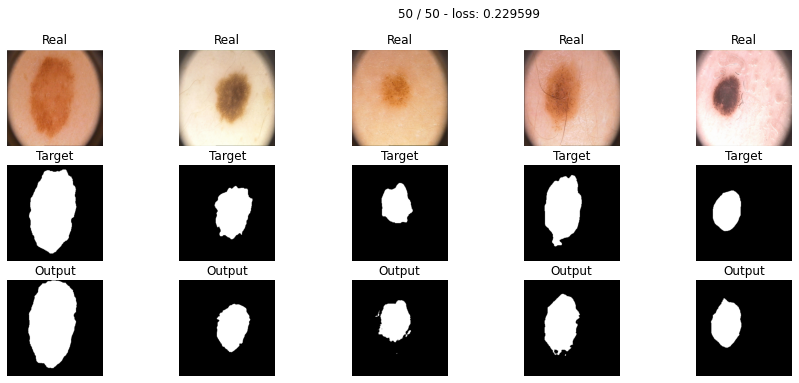

In [ ]:
model = SegNet()
model.to(device)
max_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=0.005, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.7)
loss = bce_loss
segnet_bce_train_loss, segnet_bce_val_loss, segnet_bce_val_acc \
= train(model, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
model.to(device)
Segnet_bce = score_model(model, iou_pytorch, data_ts)
Segnet_bce

0.7695158322652181

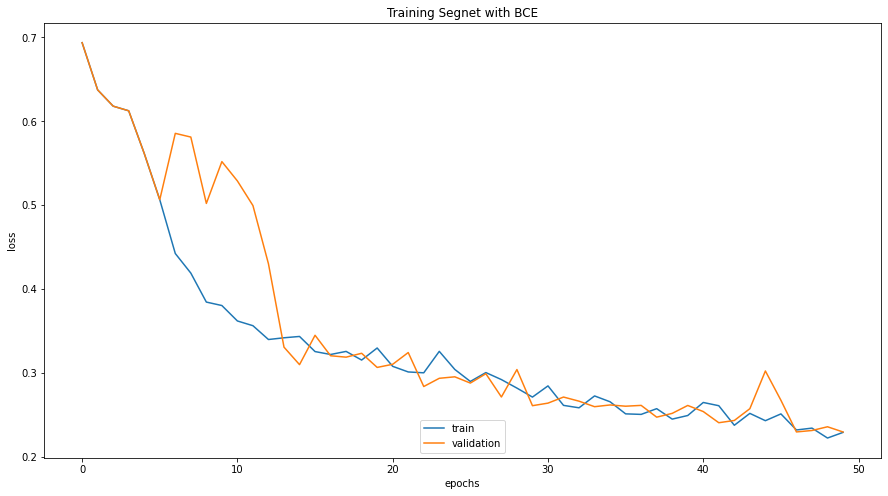

In [ ]:
segnet_bce_val_loss[:6] = segnet_bce_train_loss[:6]
plt.figure(figsize=(15, 8))
plt.plot(segnet_bce_train_loss, label="train")
plt.plot(segnet_bce_val_loss, label="validation")
plt.title("Training Segnet with BCE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show();

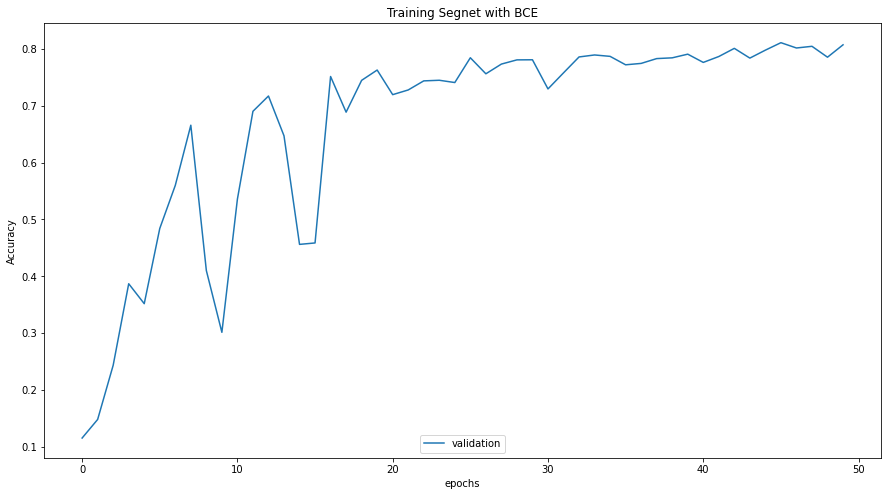

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(segnet_val_acc, label="validation")
plt.title("Training Segnet with BCE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

## DICE loss

In [ ]:
model.cpu()
#model_dice.cpu()
torch.cuda.empty_cache()
gc.collect()
!nvidia-smi

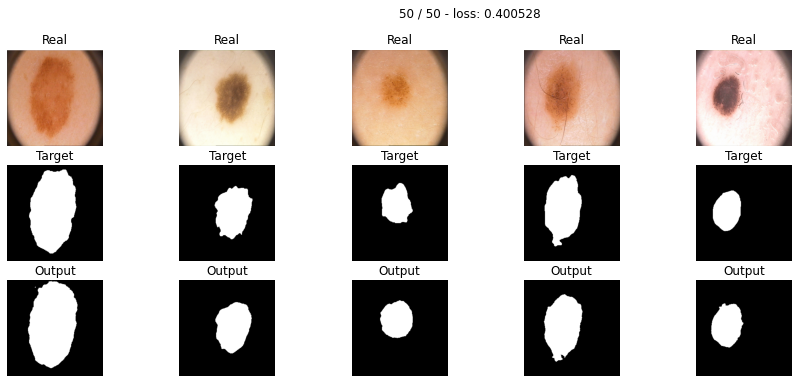

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 50
optimizer = optim.Adam(model_dice.parameters(), amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 51, gamma = 0.7)
loss = dice_loss
segnet_dice_train_loss, segnet_dice_val_loss, segnet_dice_val_acc =\
    train(model_dice, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
model_dice.to(device)
Segnet_dice = score_model(model_dice, iou_pytorch, data_ts)
Segnet_dice

0.8107907772064209

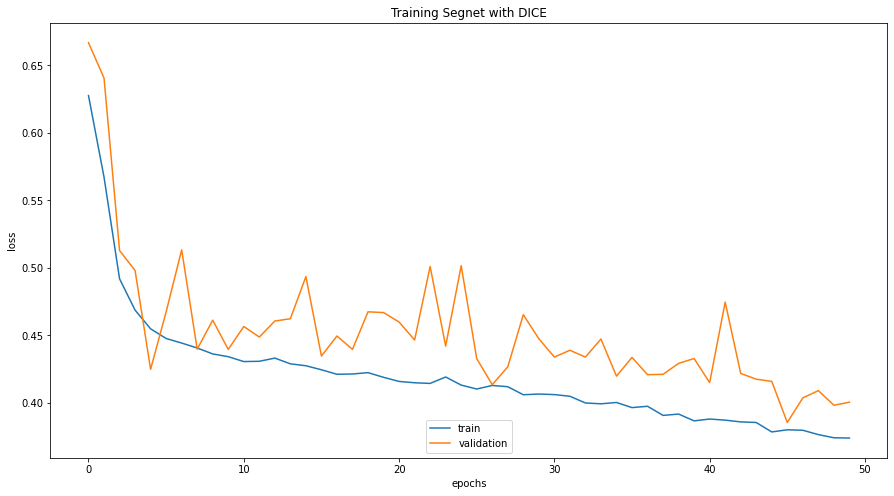

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(segnet_dice_train_loss, label="train")
plt.plot(segnet_dice_val_loss, label="validation")
plt.title("Training Segnet with DICE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

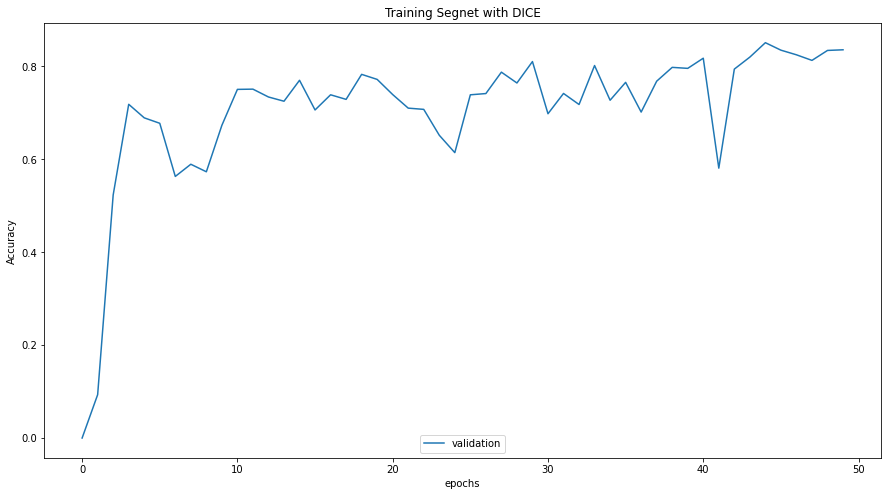

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(segnet_dice_val_acc, label="validation")
plt.title("Training Segnet with DICE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

## TVERSKY loss

In [ ]:
model_dice.cpu()
#model_tversky.cpu()
torch.cuda.empty_cache()
gc.collect();
!nvidia-smi

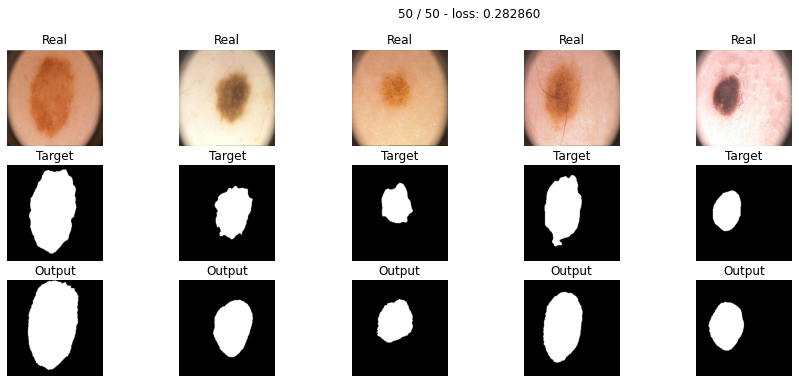

In [ ]:
model_tversky = SegNet().to(device)

max_epochs = 50
optimizer = optim.Adam(model_tversky.parameters(), lr = 0.001, amsgrad = True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 51, gamma = 0.7)
loss = tversky_loss
segnet_tversky_train_loss, segnet_tversky_val_loss, segnet_tversky_val_acc \
= train(model_tversky, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Segnet_tversky = score_model(model_tversky, iou_pytorch, data_ts)
Segnet_tversky

0.7683782577514648

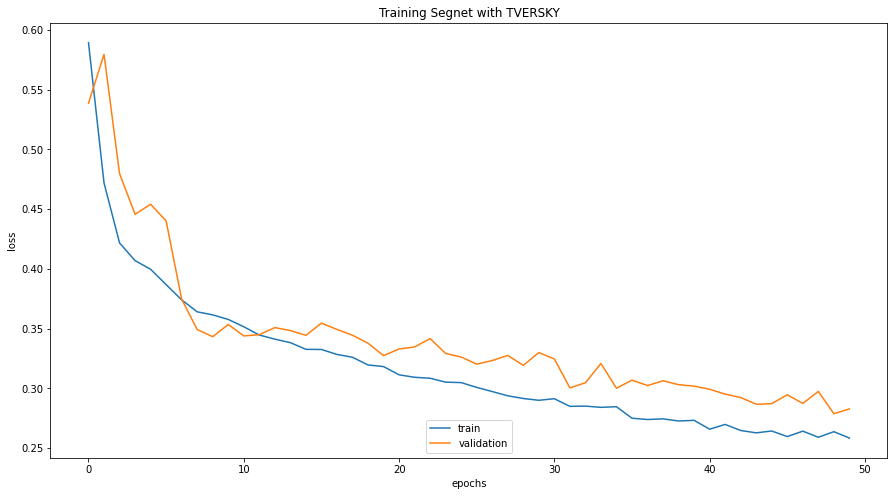

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(segnet_tversky_train_loss, label="train")
plt.plot(segnet_tversky_val_loss, label="validation")
plt.title("Training Segnet with TVERSKY")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

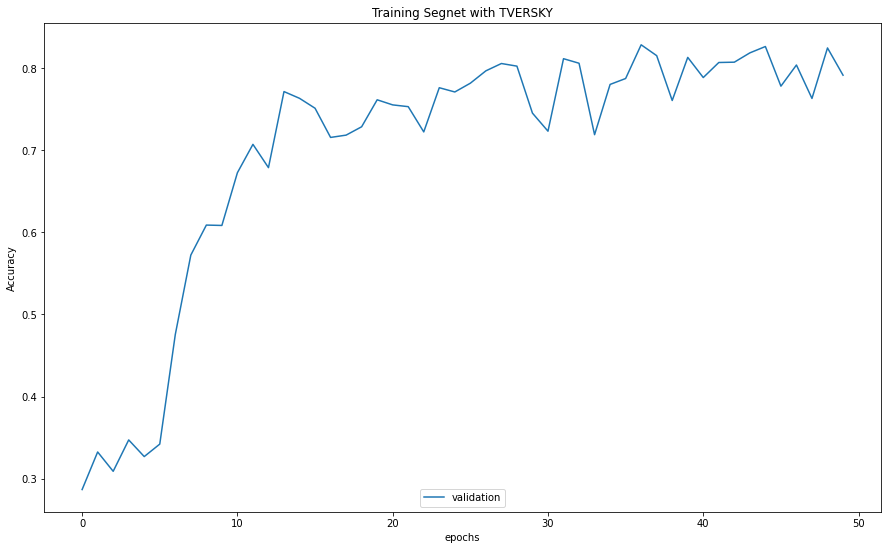

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(segnet_tversky_val_acc, label="validation")
plt.title("Training Segnet with TVERSKY")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

## FOCAL loss

In [ ]:
model_tversky.cpu()
model_focal.cpu()
torch.cuda.empty_cache()
gc.collect();
!nvidia-smi

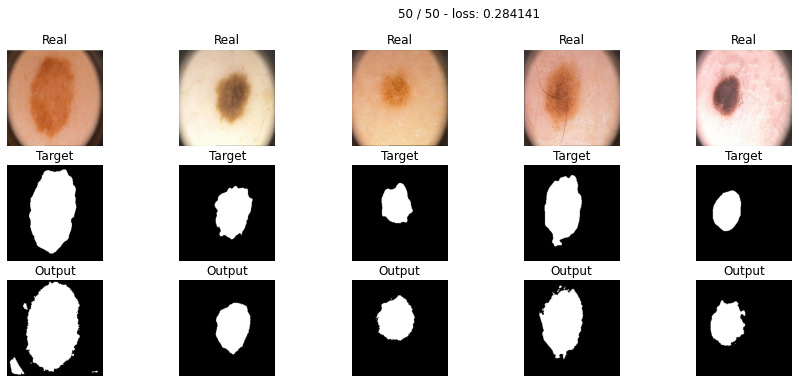

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 50
optimizer = optim.Adam(model_focal.parameters(), lr = 0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 54, gamma = 0.7)
loss = focal_loss
segnet_focal_train_loss, segnet_focal_val_loss, segnet_focal_val_acc \
= train(model_focal, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Segnet_focal = score_model(model_focal, iou_pytorch, data_ts)
Segnet_focal

0.7549344499905905

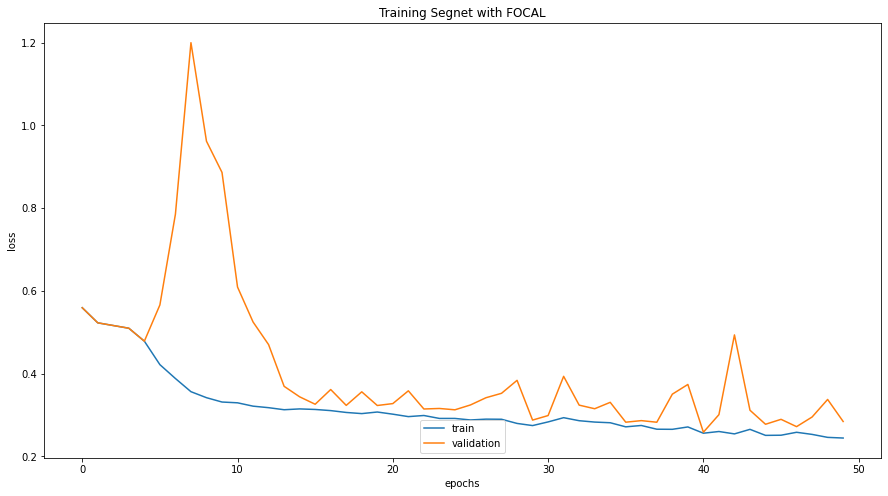

In [ ]:
segnet_focal_val_loss[:5] = segnet_focal_train_loss[:5]
plt.figure(figsize=(15, 8))
plt.plot(segnet_focal_train_loss, label="train")
plt.plot(segnet_focal_val_loss, label="validation")
plt.title("Training Segnet with FOCAL")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

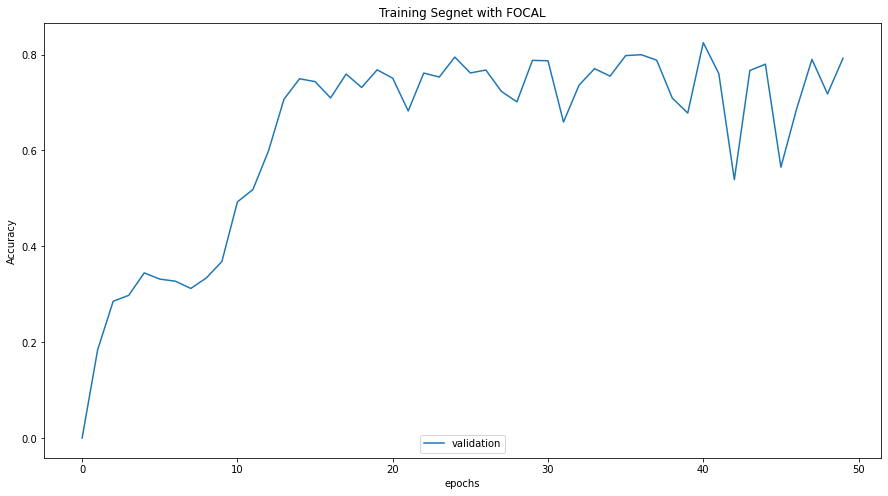

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(segnet_focal_val_acc, label="validation")
plt.title("Training Segnet with FOCAL")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

-----------------------------------------------------------------


# Обучение Unet

Обучим нашу модель. Подберем лучшие параметры оптимизатора.

## BCE loss

In [ ]:
unet_model.cpu()
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

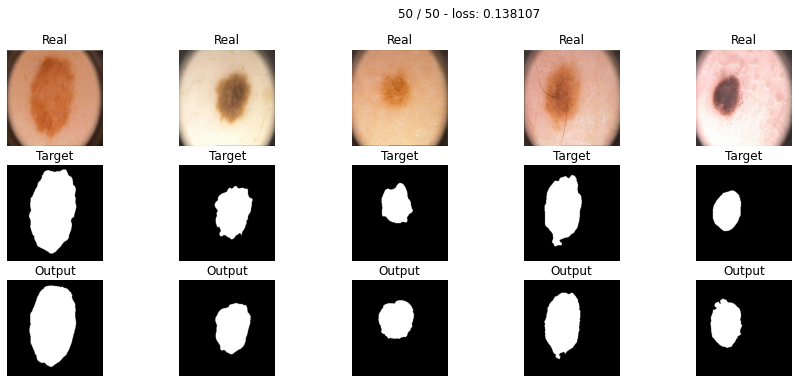

In [ ]:
unet_model = UNet().to(device)
max_epochs = 50
optimizer = optim.Adam(unet_model.parameters(), lr=0.005, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 24, gamma = 0.75)
loss = bce_loss
unet_bce_train_loss, unet_bce_val_loss, unet_bce_val_acc \
= train(unet_model, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Unet_bce = score_model(unet_model, iou_pytorch, data_ts)
Unet_bce

0.8077805439631144

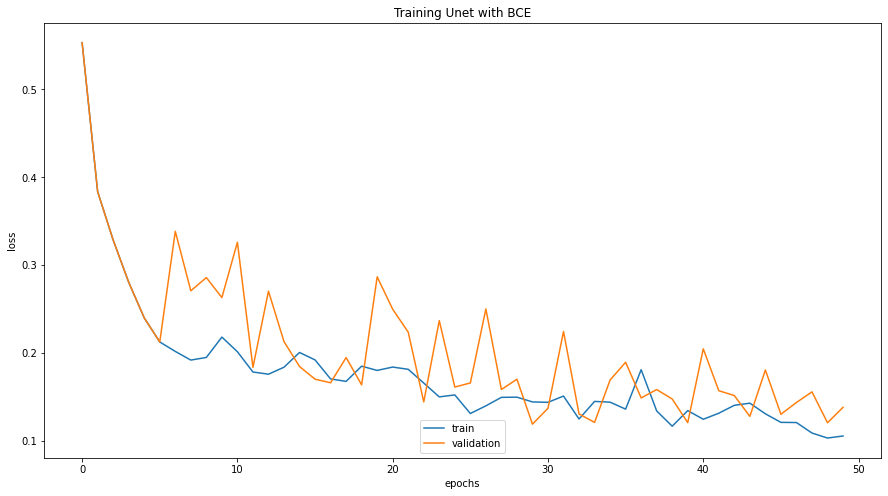

In [ ]:
unet_bce_val_loss[:6] = unet_bce_train_loss[:6]
plt.figure(figsize=(15, 8))
plt.plot(unet_bce_train_loss, label="train")
plt.plot(unet_bce_val_loss, label="validation")
plt.title('Training Unet with BCE')
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

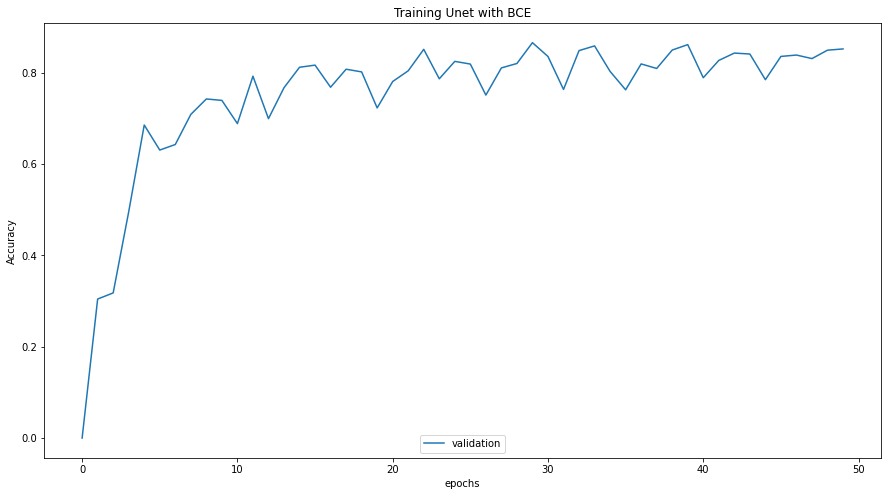

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet_bce_val_acc, label="validation")
plt.title('Training Unet with BCE')
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

## DICE loss

In [ ]:
unet_model.cpu()
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

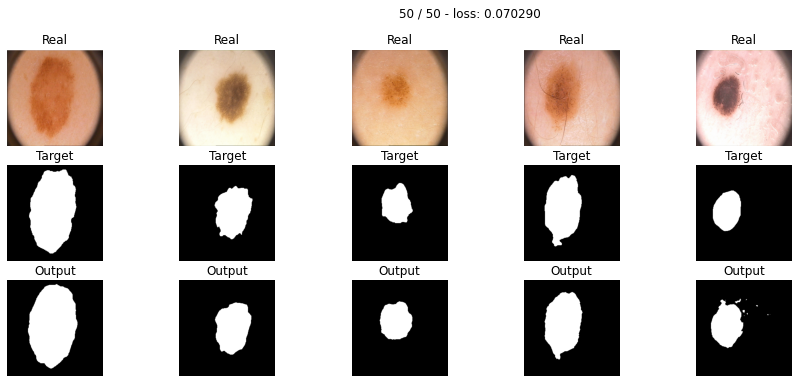

In [ ]:
unet_model = UNet().to(device)
max_epochs = 50
optimizer = optim.Adam(unet_model.parameters(), lr=0.005, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.7)
loss = dice_loss
unet_dice_train_loss, unet_dice_val_loss, unet_dice_val_acc \
= train(unet_model, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Unet_dice = score_model(unet_model, iou_pytorch, data_ts)
Unet_dice

0.8201896746953329

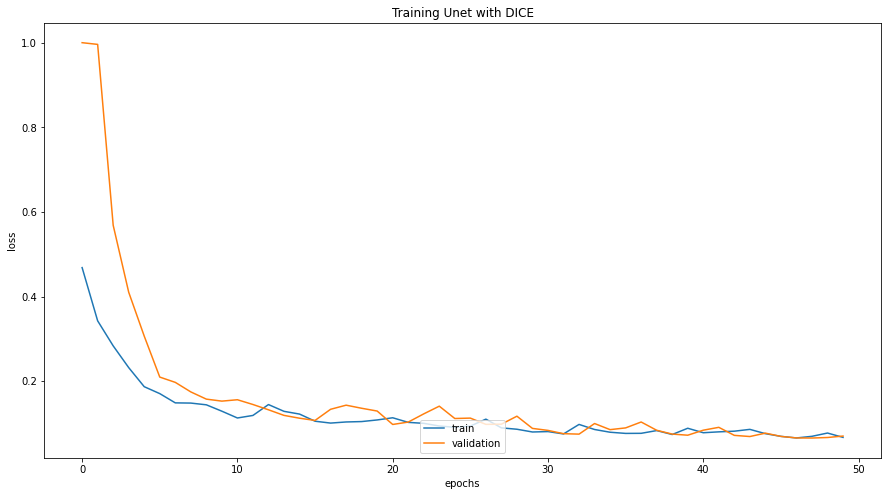

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet_dice_train_loss, label="train")
plt.plot(unet_dice_val_loss, label="validation")
plt.title("Training Unet with DICE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

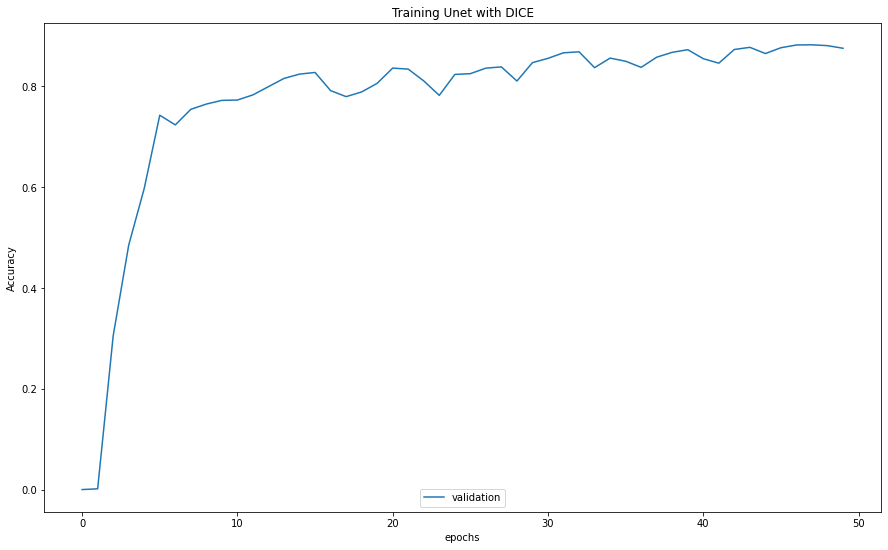

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(unet_dice_val_acc, label="validation")
plt.title("Training Unet with DICE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

## TVERSKY loss

In [ ]:
unet_model.cpu()
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

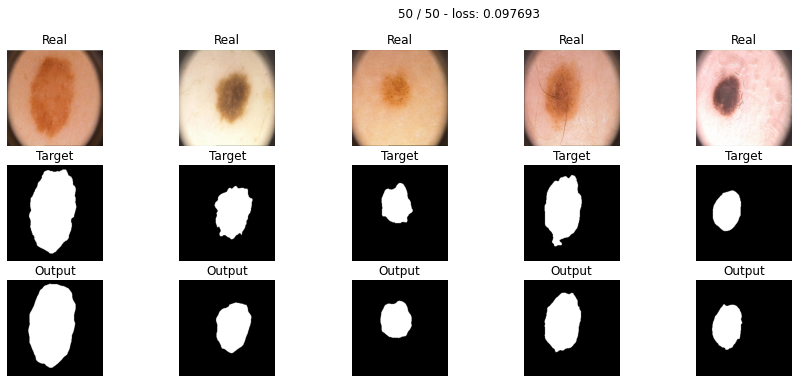

In [ ]:
unet_model = UNet().to(device)
max_epochs = 50
optimizer = optim.Adam(unet_model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 51, gamma = 0.7)
loss = tversky_loss
unet_tversky_train_loss, unet_tversky_val_loss, unet_tversky_val_acc \
= train(unet_model, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Unet_tversky = score_model(unet_model, iou_pytorch, data_ts)
Unet_tversky

0.8173032601674398

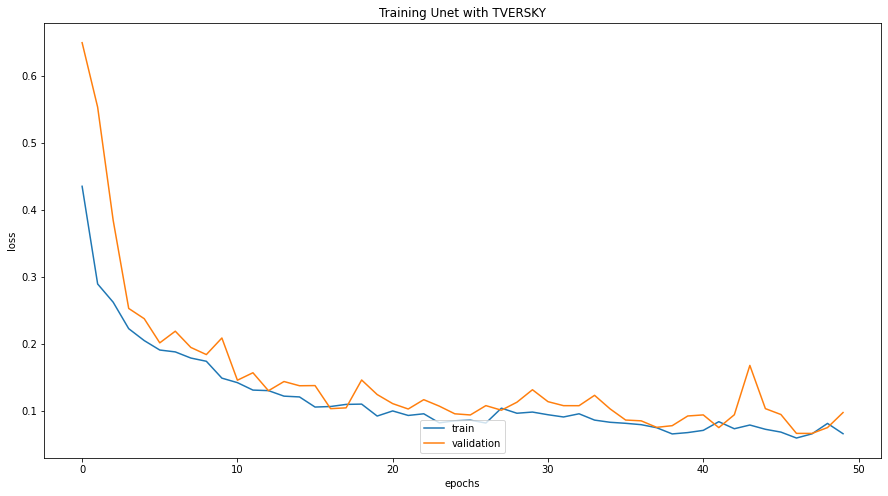

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet_tversky_train_loss, label="train")
plt.plot(unet_tversky_val_loss, label="validation")
plt.title('Training Unet with TVERSKY')
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

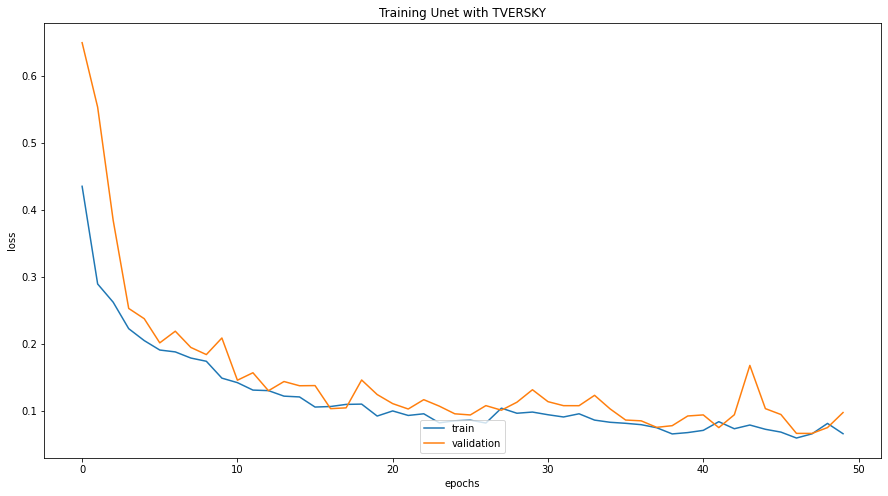

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet_tversky_train_loss, label="train")
plt.plot(unet_tversky_val_loss, label="validation")
plt.title('Training Unet with TVERSKY')
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## FOCAL loss

In [ ]:
unet_model.cpu()
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

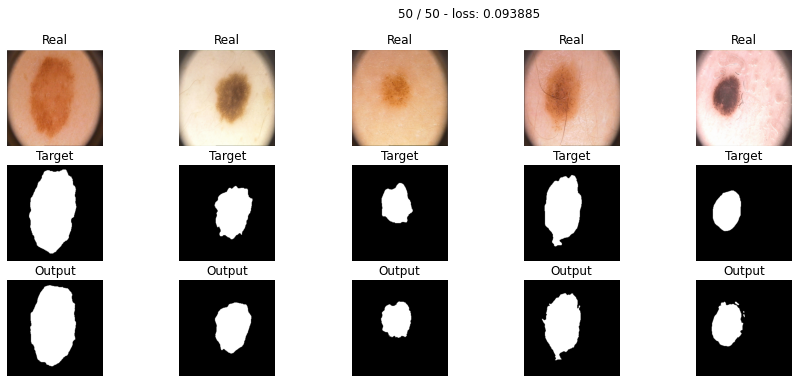

In [ ]:
unet_model = UNet().to(device)
max_epochs = 50
optimizer = optim.Adam(unet_model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 54, gamma = 0.7)
loss = focal_loss
unet_focal_train_loss, unet_focal_val_loss, unet_focal_val_acc \
= train(unet_model, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Unet_focal = score_model(unet_model, iou_pytorch, data_ts)
Unet_focal

0.7900644342104594

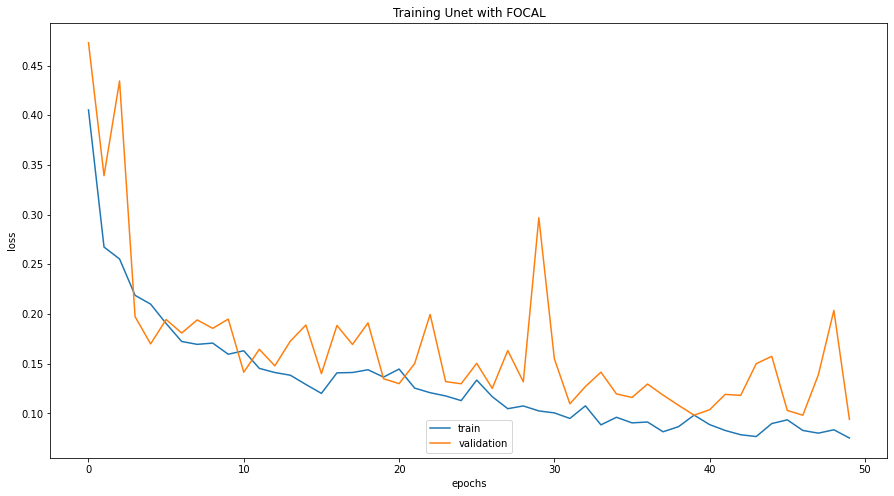

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet_focal_train_loss, label="train")
plt.plot(unet_focal_val_loss, label="validation")
plt.title("Training Unet with FOCAL")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

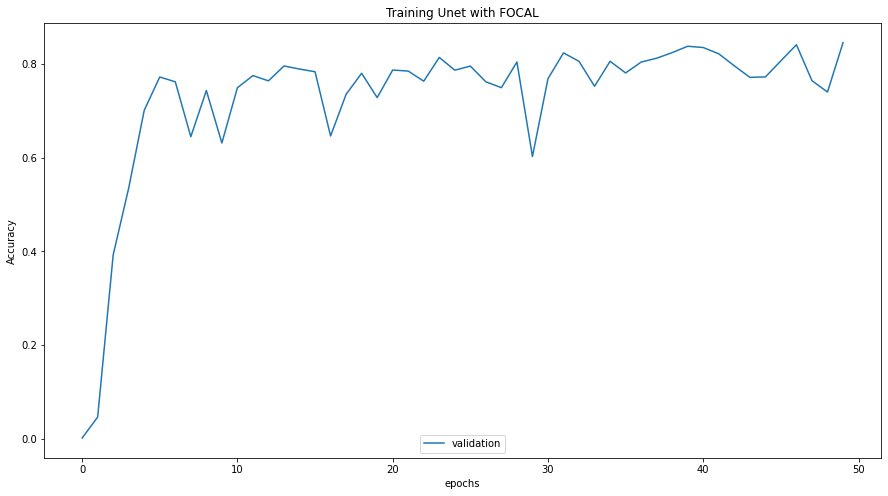

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet_focal_val_acc, label="validation")
plt.title("Training Unet with FOCAL")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

-----------------------------------------------------------------


# Обучение Unet2

Обучим нашу модель. Подберем лучшие параметры оптимизатора.

## BCE loss

In [ ]:
unet_model.cpu()
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

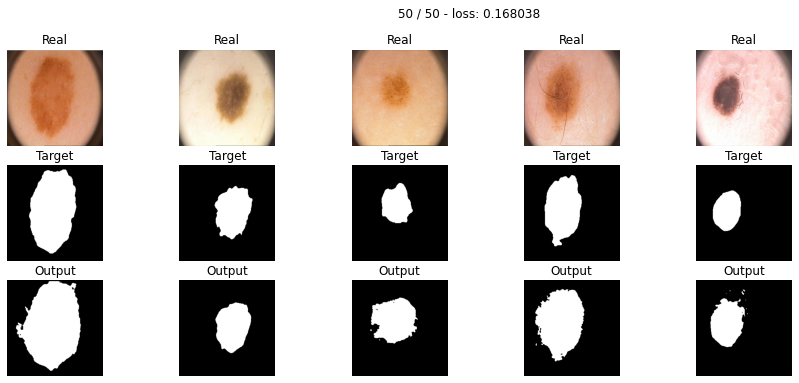

In [ ]:
unet2_model = UNet2().to(device)
max_epochs = 50
optimizer = optim.Adam(unet2_model.parameters(), lr=0.005, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.7)
loss = bce_loss
unet2_bce_train_loss, unet2_bce_val_loss, unet2_bce_val_acc \
= train(unet2_model, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Unet2_bce = score_model(unet2_model, iou_pytorch, data_ts)
Unet2_bce

0.7431590755780538

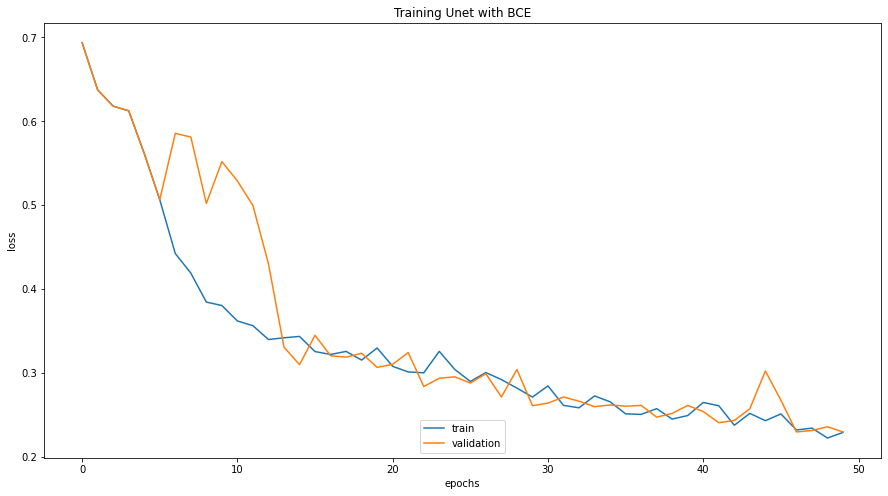

In [ ]:
unet2_bce_val_loss[:6] = unet2_bce_train_loss[:6]
plt.figure(figsize=(15, 8))
plt.plot(segnet_bce_train_loss, label="train")
plt.plot(segnet_bce_val_loss, label="validation")
plt.title("Training Unet with BCE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show();

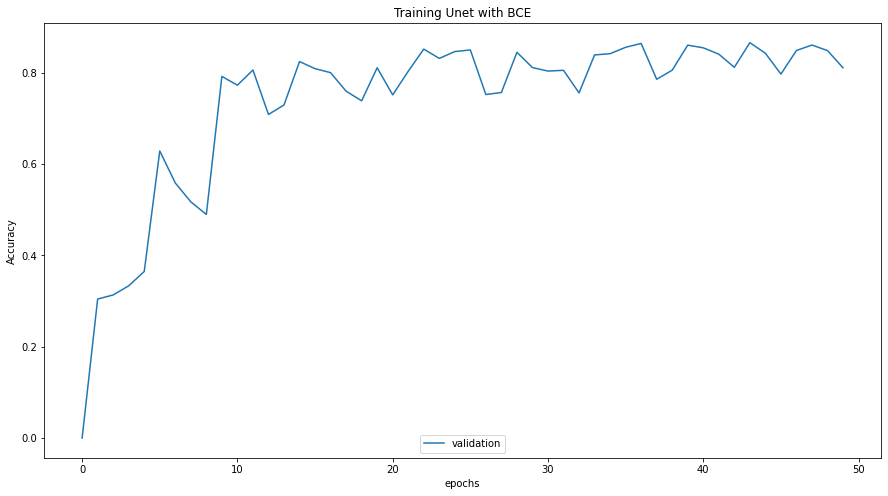

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet2_bce_val_acc, label="validation")
plt.title("Training Unet with BCE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

## DICE loss

In [ ]:
unet2_model.cpu()
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

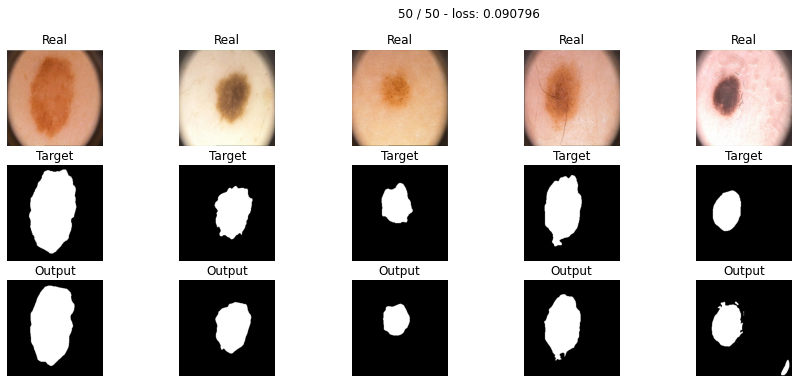

In [ ]:
unet2_model = UNet2().to(device)
max_epochs = 50
optimizer = optim.Adam(unet2_model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 51, gamma = 0.7)
loss = dice_loss
unet2_dice_train_loss, unet2_dice_val_loss, unet2_dice_val_acc \
= train(unet2_model, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Unet2_dice = score_model(unet2_model, iou_pytorch, data_ts)
Unet2_dice

0.7584261695543925

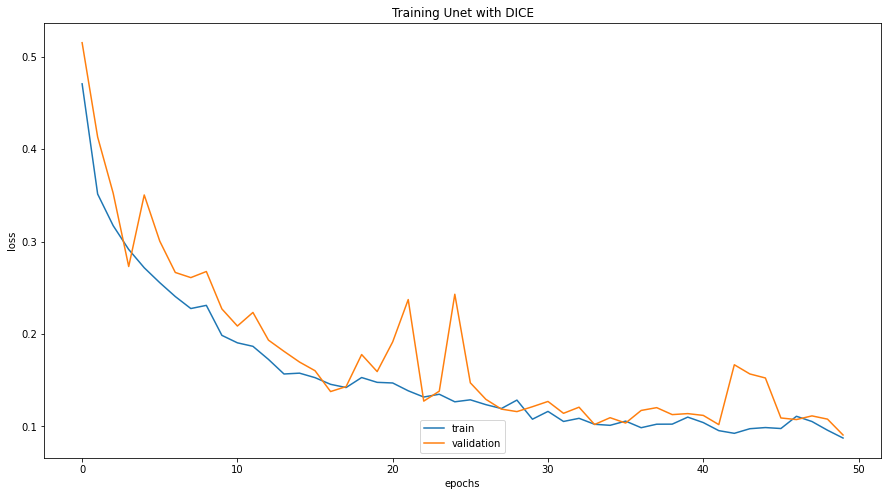

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet2_dice_train_loss, label="train")
plt.plot(unet2_dice_val_loss, label="validation")
plt.title("Training Unet with DICE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

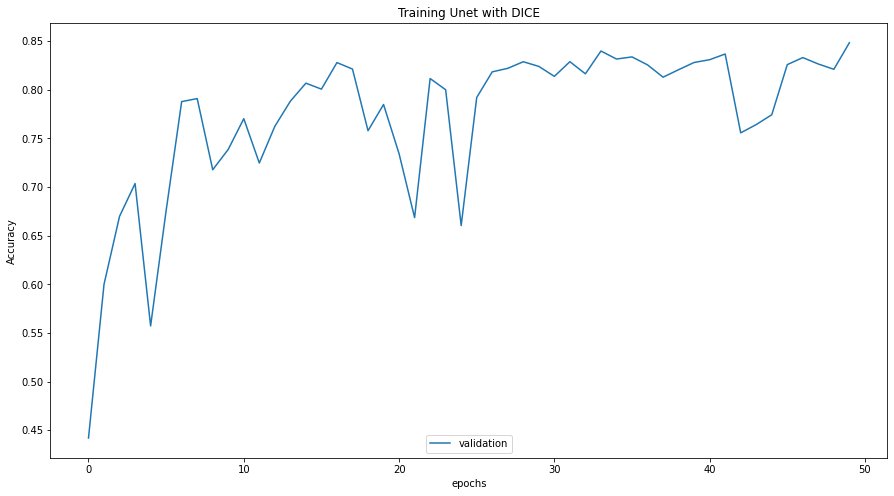

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet2_dice_val_acc, label="validation")
plt.title("Training Unet with DICE")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

## TVERSKY loss

In [ ]:
unet2_model.cpu()
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

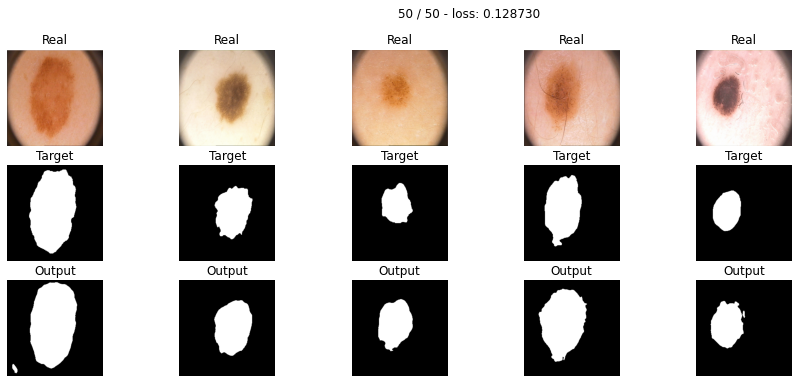

In [ ]:
unet2_model = UNet2().to(device)
max_epochs = 50
optimizer = optim.Adam(unet2_model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 51, gamma = 0.7)
loss = tversky_loss
unet2_tversky_train_loss, unet2_tversky_val_loss, unet2_tversky_val_acc \
= train(unet2_model, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Unet2_tversky = score_model(unet2_model, iou_pytorch, data_ts)
Unet2_tversky

0.7308320800463358

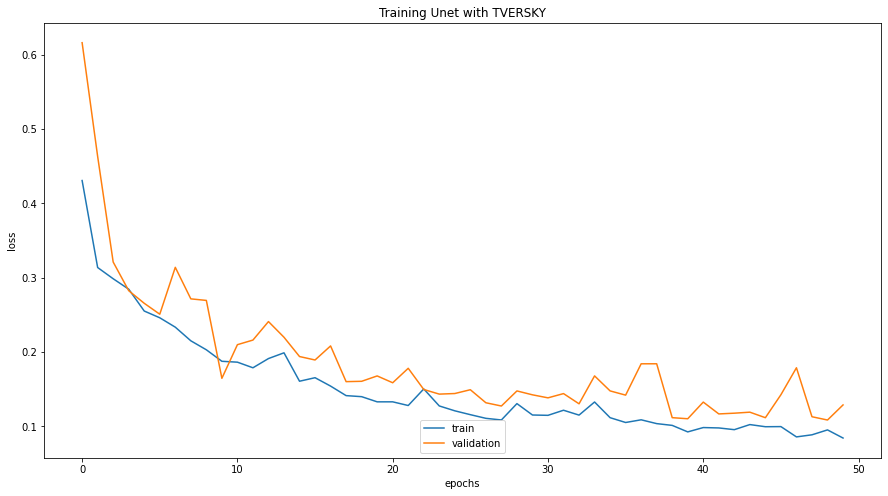

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet2_tversky_train_loss, label="train")
plt.plot(unet2_tversky_val_loss, label="validation")
plt.title("Training Unet with TVERSKY")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

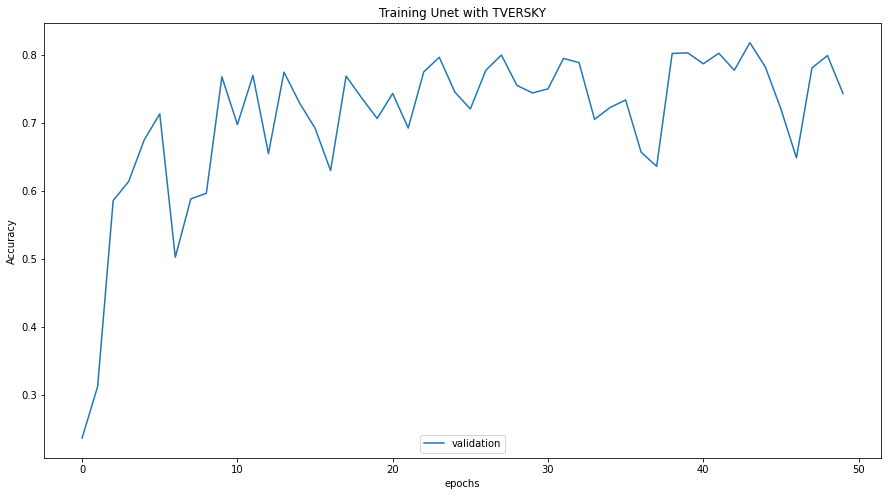

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet2_tversky_val_acc, label="validation")
plt.title("Training Unet with TVERSKY")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

## FOCAL loss

In [ ]:
unet2_model.cpu()
model_focal.cpu()
model_dice.cpu()
model.cpu()
unet_model.cpu()
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

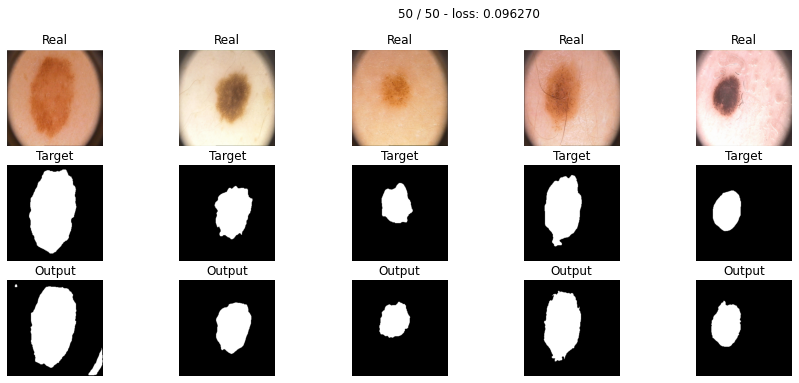

In [ ]:
unet2_model = UNet2().to(device)
max_epochs = 50
optimizer = optim.Adam(unet2_model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 64, gamma = 0.7)
loss = focal_loss
unet2_focal_train_loss, unet2_focal_val_loss, unet2_focal_val_acc \
= train(unet2_model, optimizer, loss, scheduler, max_epochs, data_tr, data_val)

In [ ]:
Unet2_focal = score_model(unet2_model, iou_pytorch, data_ts)
Unet2_focal

0.7914520899454752

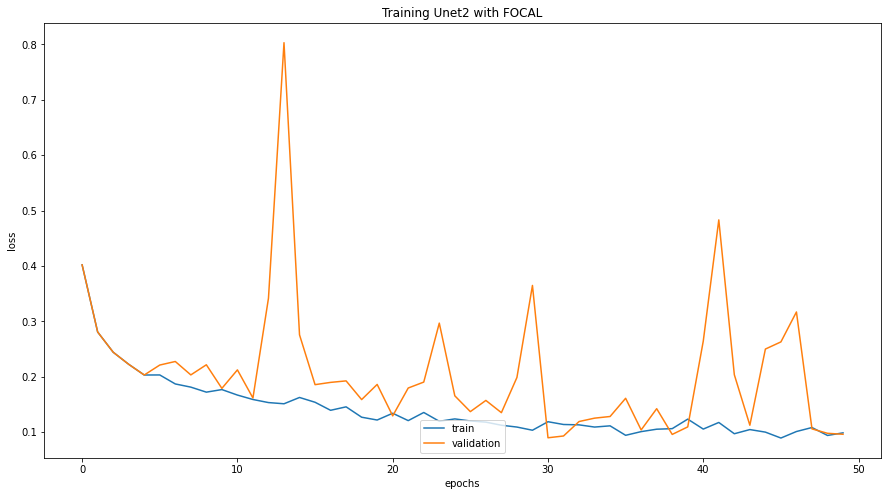

In [ ]:
unet2_focal_val_loss[:5] = unet2_focal_train_loss[:5]
plt.figure(figsize=(15, 8))
plt.plot(unet2_focal_train_loss, label="train")
plt.plot(unet2_focal_val_loss, label="validation")
plt.title("Training Unet2 with FOCAL")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

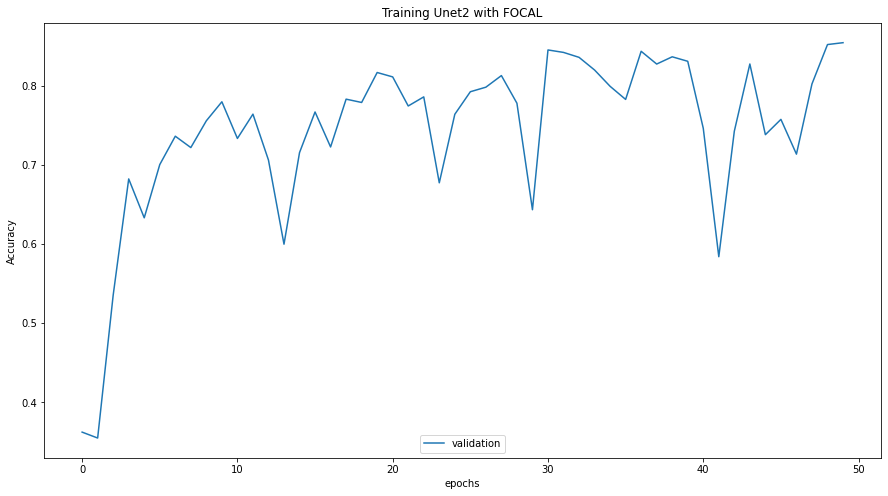

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(unet2_focal_val_acc, label="validation")
plt.title("Training Unet2 with FOCAL")
plt.legend(loc='lower center')
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.show()

#**Отчет**
В ходе данной работы были реализованы различные функции потерь и архитектуры нейросетей, использующихся для сегментации изображений, Segnet и Unet. Проведены сравнения качества сегментации при различных лосс-функциях по метрике IoU. Построены графики изменений лосс функции на тренировке и метрики на валидации для каждой архитектуры и функции потерь. Также, в работе представлено сравнение значений метрики на тестовой части датасета.

> **Segnet**

Архитектура состоит из нескольких последовательных сверточных слоев кодировщика с pooling слоями после каждого блока и такого же количества сверточных слоев декодировщика с unpooling слоями. В качестве pooling/unpooling слоев выбраны MaxPool2d с запоминанием индексов и MaxUnpool2d соответственно.

Количество обучаемых параметров: 27M

***Результат обучения на 50 эпохах***

Достигнутое качество: 0,75-0,81


Наилучшим образом модель обучается с BCE Loss. Наиболее стабильным является Tversky loss. Dice loss не показывает низких значений на валидации, что не мешает ему обучить модель с лучшим качеством и на валидационной, и на тестовой выборке. Focal же лосс имеет не такой сглаженный график как другие, на нем присутсвуют умеренные скачки значений.

-------------------------------------------------------------

> **Unet**

Архитектура состоит из нескольких последовательных сверточных слоев кодировщика без изменений размеров карты признаков с pooling слоями после каждого блока,соединенных за счет Skip connection блоков с таким же количеством сверточных слоев декодировщика с unpooling слоями. В качестве pooling/unpooling слоев выбраны MaxPool2d и Unpsample с 'Nearest Neigbourhood' интерполяцией соответственно.

Количество обучаемых параметров: 22M

***Результат обучения на 50 эпохах***

Достигнутое качество: 0,79-0,82

Наилучшим образом модель обучается с Dice Loss, при этом имеет достаточное сглаженное увелечение значения метрики на валидации. Также Dice loss повзволяет обучить модель с лучшим качеством и на валидационной, и на тестовой выборке. Focal лосс, как и в случае с SegNet, имеет график c умеренными скачками значений лосса. BCE loss в свою очередь имеет почти переодические скачки.

-------------------------------------------------------------

> **Unet2**

Архитектура состоит из нескольких последовательных сверточных слоев кодировщика без изменений размеров карты признаков с pooling слоями после каждого блока,соединенных за счет Skip connection блоков с таким же количеством сверточных слоев декодировщика с unpooling слоями. В качестве pooling/unpooling слоев выбраны Conv2d и ConvTranspose2d соответственно.

Количество обучаемых параметров: 28M

***Результат обучения на 50 эпохах***

Достигнутое качество: 0,73-0,79

Наилучшим образом модель обучается с Dice Loss, при этом имеет достаточное сглаженное увелечение значения метрики на валидации. Также Dice loss повзволяет обучить модель с лучшим качеством и на валидационной, и 2 по величине на тестовой выборке. Focal лосс имеет график c сильными скачками значений лосса, тем не менее модель, обученная на нем, показывает лучший результат на тесте. BCE loss в свою очередь имеет почти переодические скачки.


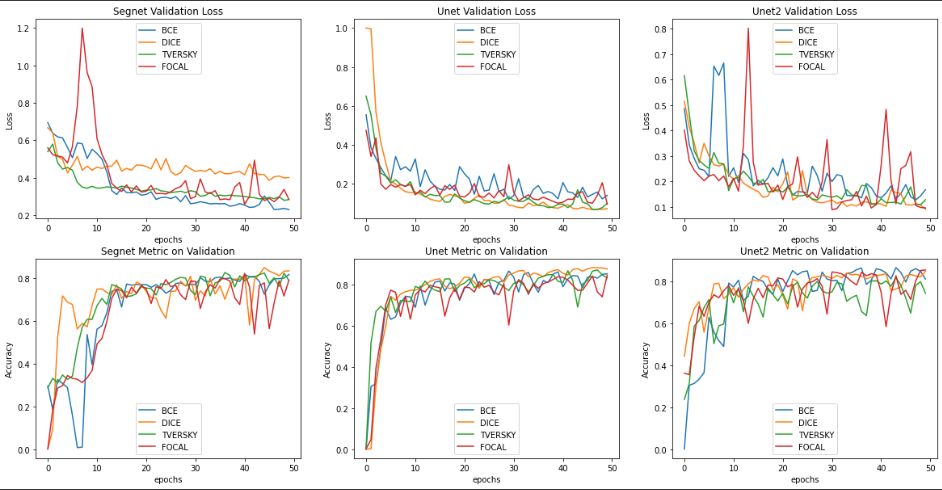

In [ ]:
result = pd.DataFrame(models, index = ['BCE', 'DICE','TVERSKY', 'FOCAL'])
result

,SegNet,UNet,UNet2
BCE,0.7695,0.8078,0.7432
DICE,0.8108,0.8202,0.7584
TVERSKY,0.7684,0.8173,0.7308
FOCAL,0.7549,0.7901,0.7915


-------------------------------------------------------------
*Примечание* :

*   Существуют различные варианты реализаций архитектур рассмотренных нейросетей, в связи с этим в отчете присутствует пояснение основных моментов имплементации.
*   Обучение было проведено при определенных параметрах оптимайзера, шедулера, разбиении датасета и ограниченном количестве эпох. Поэтому окончательную оценку качества сегментации однозначно назвать не представляется возможным. При других параметрах качество может быть выше.

## Предикшн

In [ ]:
_, Y_test = next(iter(data_ts))
plt.figure(figsize=(18, 6))
for k in range(20):
    plt.subplot(4, 5, k+1)
    plt.imshow(Y_test[k,0].detach().cpu().numpy(), cmap='gray')
    plt.title('Test')
    plt.axis('off')

In [ ]:
Y_pred = predict(model, data_ts)
plt.figure(figsize=(18, 6))
for k in range(20):
    plt.subplot(4, 5, k+1)
    plt.imshow(Y_pred[0][k,0].detach().cpu().numpy(), cmap='gray')
    plt.title('Predict')
    plt.axis('off')

In [ ]:
models = {'SegNet': [round(Segnet_bce, 4), round(Segnet_dice, 4), round(Segnet_tversky, 4), round(Segnet_focal, 4)],\
          'UNet': [round(Unet_bce, 4), round(Unet_dice, 4), round(Unet_tversky, 4), round(Unet_focal, 4)],\
          'UNet2': [round(Unet2_bce, 4), round(Unet2_dice, 4), round(Unet2_tversky, 4), round(Unet2_focal, 4)]}

Text(0, 0.5, 'Accuracy')

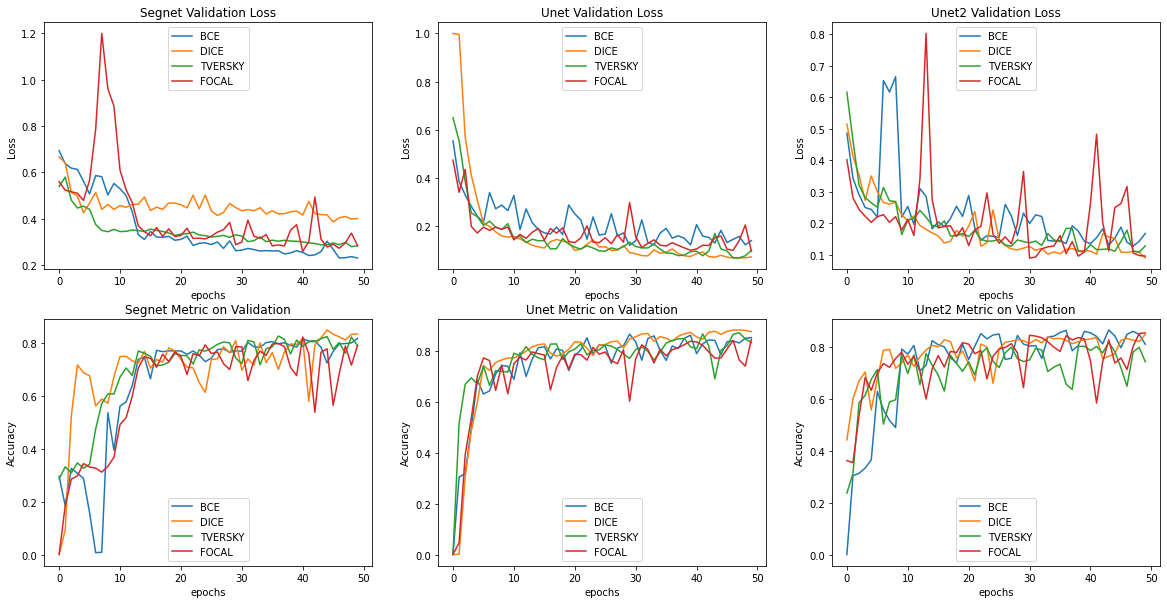

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.plot(segnet_bce_val_loss, label="BCE")
plt.plot(segnet_dice_val_loss, label="DICE")
plt.plot(segnet_tversky_val_loss, label="TVERSKY")
plt.plot(segnet_focal_val_loss, label="FOCAL")
plt.legend(loc='upper center')
plt.title('Segnet Validation Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")

plt.subplot(2, 3, 2)
plt.plot(unet_bce_val_loss, label="BCE")
plt.plot(unet_dice_val_loss, label="DICE")
plt.plot(unet_tversky_val_loss, label="TVERSKY")
plt.plot(unet_focal_val_loss, label="FOCAL")
plt.legend(loc='upper center')
plt.title('Unet Validation Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")

plt.subplot(2, 3, 3)
plt.plot(unet2_bce_val_loss, label="BCE")
plt.plot(unet2_dice_val_loss, label="DICE")
plt.plot(unet2_tversky_val_loss, label="TVERSKY")
plt.plot(unet2_focal_val_loss, label="FOCAL")
plt.legend(loc='upper center')
plt.title('Unet2 Validation Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")

plt.subplot(2, 3, 4)
plt.plot(segnet_bce_val_acc, label="BCE")
plt.plot(segnet_dice_val_acc, label="DICE")
plt.plot(segnet_tversky_val_acc, label="TVERSKY")
plt.plot(segnet_focal_val_acc, label="FOCAL")
plt.legend(loc='lower center')
plt.title('Segnet Metric on Validation')
plt.xlabel("epochs")
plt.ylabel("Accuracy")

plt.subplot(2, 3, 5)
plt.plot(unet_bce_val_acc, label="BCE")
plt.plot(unet_dice_val_acc, label="DICE")
plt.plot(unet_tversky_val_acc, label="TVERSKY")
plt.plot(unet_focal_val_acc, label="FOCAL")
plt.legend(loc='lower center')
plt.title('Unet Metric on Validation')
plt.xlabel("epochs")
plt.ylabel("Accuracy")

plt.subplot(2, 3, 6)
plt.plot(unet2_bce_val_acc, label="BCE")
plt.plot(unet2_dice_val_acc, label="DICE")
plt.plot(unet2_tversky_val_acc, label="TVERSKY")
plt.plot(unet2_focal_val_acc, label="FOCAL")
plt.legend(loc='lower center')
plt.title('Unet2 Metric on Validation')
plt.xlabel("epochs")
plt.ylabel("Accuracy")